In [36]:
import gym
from gym import spaces
import numpy as np
from collections import deque
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from datetime import datetime

In [37]:
import cv2

In [38]:
from plotly import express as px
from plotly import graph_objects as go

In [39]:
from copy import deepcopy

import os

from torch import nn
import torch
import random 

from tqdm.notebook import tqdm
from torchvision import transforms as T

In [40]:
action_mapping_dict = {
    0:0,
    1:2,
    2:3
}
env_action_mapping_dict = {k:v for k,v in action_mapping_dict.items()}

class RemoveActions(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def step(self, action):        
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()
        _,_,done,_ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs
        
    

### Constants

In [41]:
device = 'cuda:1'
save_path = '/data/zabolotny-av/RL/logs'

### Init enviroment

In [42]:

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condition for a few
            # frames so it's important to keep lives > 0, so that we only reset
            # once the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=6):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        shape = (2, ) + env.observation_space.shape
        self._obs_buffer = np.zeros(shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = info = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    @staticmethod
    def reward(reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        shape = (1 if self.grayscale else 3, self.height, self.width)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=np.uint8
        )

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        size = (self.width, self.height)
        frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame.transpose((2, 0, 1))


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also `LazyFrames`
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        shape = (shp[0] * k, ) + shp[1:]
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=env.observation_space.dtype
        )

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return np.asarray(self._get_ob())

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return np.asarray(self._get_ob()), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are
        only stored once. It exists purely to optimize memory usage which can be
        huge for DQN's 1M frames replay buffers.
        This object should only be converted to numpy array before being passed
        to the model. You'd not believe how complex the previous solution was.
        """
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-3)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0
    
    
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env, width=84, height=84)
    env = MaxAndSkipEnv(env, skip=4)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env


In [43]:
env = gym.make('PongNoFrameskip-v4')
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4,
                                      screen_size=84, terminal_on_life_loss=False, 
                                      grayscale_obs=True, grayscale_newaxis=False, 
                                      scale_obs=False)
env = gym.wrappers.FrameStack(env, 4)

In [44]:
N_ACTIONS = int(env.action_space.n)
N_ACTIONS = 4

### DQN

In [45]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
    
        
        # self.act = torch.nn.Sigmoid()
        self.act = torch.nn.ReLU()
        
        self.head = torch.nn.Sequential(
            nn.Linear(7 * 7 * 64, 512),
            self.act, 
            nn.Linear(512, 512),
            self.act, 
            nn.Linear(512, N_ACTIONS)
        )

    def forward(self, x):
        x = (x - 0.416376) / 0.1852287
        bs = x.shape[0]        
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))        
        x = x.view(bs, -1)        
        return self.head(x)

In [46]:
class RepalyAgent:
    def __init__(self, device='cpu', eps=0.9, path=''):
        self.device = device
        self.target_model = DQN().to(device)        
        self.target_model.load_state_dict(torch.load(path))
        self.eps = eps
        self.n_actions = N_ACTIONS
        self.batch_size = 32
        self.step = 0
        self.episode = 0
        self.GAMMA = 0.99        

    def select_action(self, state):
        state = torch.tensor([state]).to(self.device)        
        with torch.no_grad():
            best_action = self.target_model(
                state
            )
            best_action = best_action.max(1)[1]
            return best_action.item()

In [47]:
agent = RepalyAgent(device=device, path='/data/zabolotny-av/RL_experiments_DEBUG/2022-05-18 23:09:34.541097/weights/model_120.pkl')

### Replay

In [53]:
update_period = 1000
num_episodes = 1
episodes = []
episode_stats = {
    'reward' : [],
    'episode_len' : [],
    'loss' : [],
    'mean_loss' : []
}
for i_episode in range(0, num_episodes):            
    episode_stats['reward'].append(0)
    
    state = env.reset()    
    episodes.append({'states' : [], 'actions' : [], 'probs' : [], 'reward' : []})
    for step in tqdm(range(5000)):
        action = agent.select_action(state)        
        episodes[-1]['states'].append(state)
        episodes[-1]['actions'].append(action)
        probs = agent.target_model(torch.tensor(state)[None].to(device))[0].detach().cpu().numpy()
        episodes[-1]['probs'].append(probs)
        
        next_state, reward, done, _ = env.step(action)   
        episodes[-1]['reward'].append(reward)
        
        episode_stats['reward'][-1] += reward        
        
        if done:
            next_state = None
        
        state = next_state
        
        
        if done:
            break   

    actions = episodes[-1]['actions']
    print(pd.Series(actions).value_counts() / len(actions))
    print(episode_stats['reward'][-1])
        
        

  0%|          | 0/5000 [00:00<?, ?it/s]

/data2/zabolotny-av/conda/envs/zab-ds/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



3    0.453603
2    0.210551
0    0.179934
1    0.155911
dtype: float64
-9.0


In [59]:
images = episodes[0]['states'][::]
images = torch.tensor(images)[:,0]

In [61]:
from PIL import Image

In [74]:
pil_images = (Image.fromarray(i.numpy()).resize((256,256)) for i in images)
pil_images_iterator = next(pil_images)

In [75]:
pil_images_iterator.save(fp='pong_game.gif', format='GIF', append_image=pil_images, save_all=True, duration=10, loop=0)

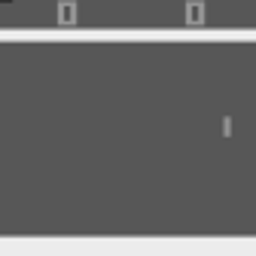

In [76]:
pil_images_iterator

In [78]:
ds = episodes[0]['states'][::10]
fig = px.imshow(torch.tensor(ds)[:,0],
                animation_frame=0,
                labels=dict(animation_frame="slice"),
                color_continuous_scale='gray')
fig.show()